# DESI Imaging Validation 


## Introduction

This is the User Notebook to run validation tests at NERSC
You only need to input your localdir (at NERSC) to save outputs.

Each cell should have one test <br>
To run a test you need to input<br>
*    survey: DECaLS/BASS/MZLS  
*    release: DR3/DR4 
*    bands: g,r,z
*    localdir: yourdirectory 
*    verbose: true/false 
<br>

Output: path to png image to plot 

## Enter your directory for outputs

In [1]:
from desi_image_validation import *
from IPython.display import Image
from astropy.io import fits
import scipy.signal
import matplotlib.pyplot as plt
#%matplotlib inline  

In [46]:
#help(scipy.signal);

In [2]:
localdir = '/global/homes/m/manera/DESI/validation-outputs/'

# Validation Tests 

### Sanity check to see the hardcoded values of a sample

In [3]:
verbose=False
sample=mysample('DECaLS','DR5','g',localdir,verbose)

# TEST Information 
print '----- check values sample ----'
print 'band = ', sample.band
print 'localdir = ', sample.localdir
print 'survey = ', sample.survey
print 'DR = ', sample.DR
print 'path ccd = ',sample.ccds
print '----------'
print 'zp0 = ', sample.zp0
print 'extinction coef = ', sample.extc
print 'extinction raw = ', sample.be
print 'magnitude limit = ', sample.recm
print 'photoz req = ', sample.phreq
print 'catalogue = ', sample.catalog
print  'verbose = ', sample.verbose
print 'fraction of exposures = ', sample.FracExp
print '------------------------'
print '                        '

creating directory for plots /global/homes/m/manera/DESI/validation-outputs/DECaLS_DR5
----- check values sample ----
band =  g
localdir =  /global/homes/m/manera/DESI/validation-outputs/
survey =  DECaLS
DR =  DR5
path ccd =  /global/project/projectdirs/cosmo/data/legacysurvey/dr5/ccds-annotated-dr5.fits.gz
----------
zp0 =  25.08
extinction coef =  3.303
extinction raw =  1
magnitude limit =  24.0
photoz req =  0.01
catalogue =  DECaLS_DR5
verbose =  False
fraction of exposures =  [0.02, 0.24, 0.5, 0.22, 0.02]
------------------------
                        


## Temporal averages

/global/common/cori/contrib/desi/code/desiconda/20170414-1.1.2-imaging_conda/lib/python2.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/global/common/cori/contrib/desi/code/desiconda/20170414-1.1.2-imaging_conda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/global/common/cori/contrib/desi/code/desiconda/20170414-1.1.2-imaging_conda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


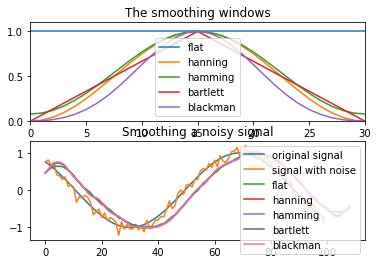

In [6]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y




from numpy import *
from pylab import *

def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()


if __name__=='__main__':
    smooth_demo()

/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-90prime-g.fits.gz


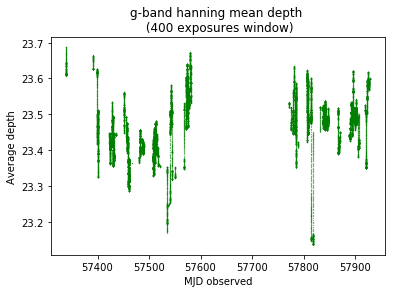

In [9]:
verbose=False
sample=mysample('BASS','DR6','g',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=401,window='flat')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[200:-200],s=0.05,c='green') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("g-band hanning mean depth \n (400 exposures window)")
plt.show()


/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-90prime-r.fits.gz


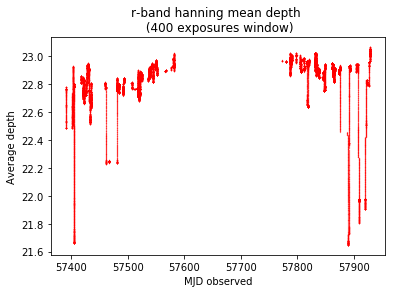

In [10]:
verbose=False
sample=mysample('BASS','DR6','r',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=401,window='flat')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[200:-200],s=0.05,c='red') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("r-band hanning mean depth \n (400 exposures window)")
plt.show()


/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-mosaic-z.fits.gz


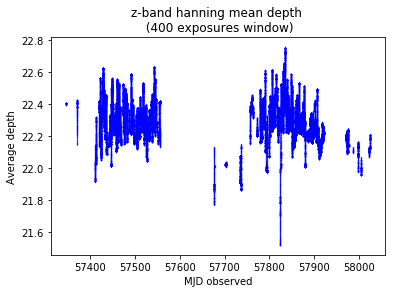

In [11]:
verbose=False
sample=mysample('MZLS','DR6','z',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=401,window='flat')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[200:-200],s=0.05,c='blue') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("z-band hanning mean depth \n (400 exposures window)")
plt.show()


/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-90prime-g.fits.gz


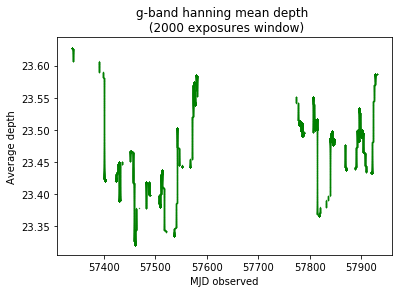

In [19]:
verbose=False
sample=mysample('BASS','DR6','g',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=2001,window='hanning')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[1000:-1000],s=0.05,c='green') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("g-band hanning mean depth \n (2000 exposures window)")
plt.show()



/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-90prime-r.fits.gz


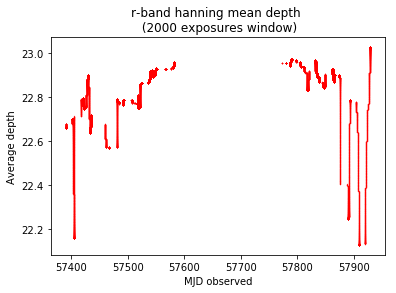

In [20]:
verbose=False
sample=mysample('BASS','DR6','r',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=2001,window='hanning')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[1000:-1000],s=0.05,c='red') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("r-band hanning mean depth \n (2000 exposures window)")
plt.show()

/global/cscratch1/sd/dstn/dr6plus/ccds-annotated-mosaic-z.fits.gz


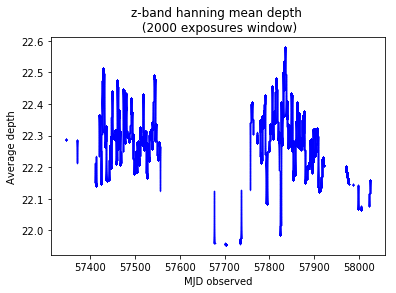

In [21]:
verbose=False
sample=mysample('MZLS','DR6','z',localdir,verbose)
print sample.ccds
hdul=fits.open(sample.ccds)
myheader=hdul[1].header
mydata=hdul[1].data
hdul.close()

galdepth=mydata['galdepth']
mjdobs=mydata['mjd_obs']
mjddepth=galdepth[mjdobs.argsort()]   # depth sorted by modified julian date
depthsmooth=smooth(mjddepth,window_len=2001,window='hanning')  #remove window in output y[200,-200]

plt.scatter(mjdobs,depthsmooth[1000:-1000],s=0.05,c='blue') 
plt.xlabel("MJD observed")
plt.ylabel("Average depth")
plt.title("z-band hanning mean depth \n (2000 exposures window)")
plt.show()



### Extinction corrected depth maps (Val 3.4c)

Visually explore the maps for depth patterns

> Projection ivar  total  took : 18.04 sec for 1349414 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 18.10 sec for 1349414 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_g_nside1024_oversamp1_hits__total.fits
Area is  2698.46676597  sq. deg.
0 of  823082  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  22.3777457024  and max  depth  =  26.0370694244
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_BASS_DR61024.png
Total pixels 823082 probably too many for exact mean and std
Mean =  24.0715056634 ; Median =  24.0476100088 ; Std =  0.160135430713
Results for 90% 95% and 98% are:  23.9152536085 23.8753174773 23.8219363214
Percentage of hits for 0,1,2., to >7 pases
[  0.00000000e+00   1.32716868e-01   2.57327996e-01   3.7424

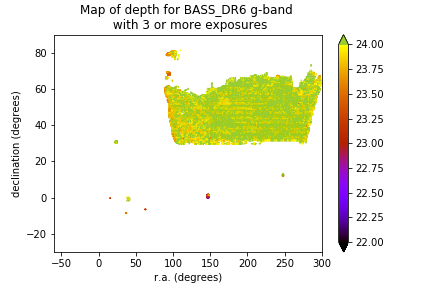

In [9]:
verbose=False
sample=mysample('BASS','DR6','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 17.93 sec for 1349303 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 18.47 sec for 1349303 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_r_nside1024_oversamp1_hits__total.fits
Area is  2942.56352011  sq. deg.
200 of  897536  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.5478027437  and max  depth  =  25.0851329046
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_BASS_DR61024.png
Total pixels 897536 probably too many for exact mean and std
Mean =  23.484260878 ; Median =  23.4819884846 ; Std =  0.194759004682
Results for 90% 95% and 98% are:  23.3092600921 23.2410636426 23.071959758
Percentage of hits for 0,1,2., to >7 pases
[  0.00000000e+00   1.31542730e-01   2.03272356e-01   3.5757

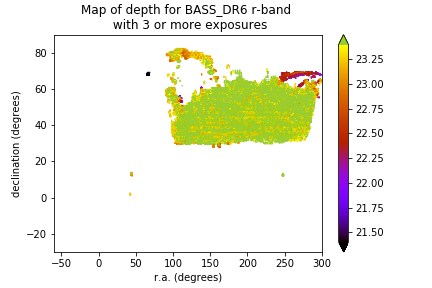

In [11]:
verbose=False
sample=mysample('BASS','DR6','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 22.39 sec for 1506382 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR6/nside1024_oversamp1/MZLS_DR6_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 23.56 sec for 1506382 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR6/nside1024_oversamp1/MZLS_DR6_band_z_nside1024_oversamp1_hits__total.fits
Area is  3709.71725372  sq. deg.
1 of  1131532  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  19.8569933426  and max  depth  =  24.4835914831
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_MZLS_DR61024.png
Total pixels 1131532 probably too many for exact mean and std
Mean =  23.0097885331 ; Median =  22.9851695311 ; Std =  0.211228503266
Results for 90% 95% and 98% are:  22.7911902606 22.7410050154 22.6783950776
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.09882752  0.15001374  0.34048601  0.285592

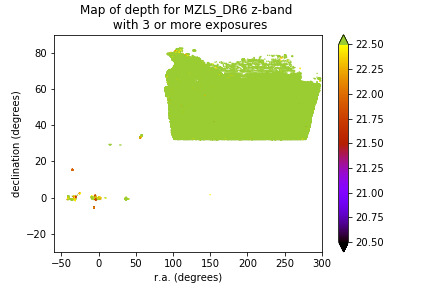

In [10]:
verbose=False
sample=mysample('MZLS','DR6','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 18.20 sec for 1349414 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 18.23 sec for 1349414 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_g_nside1024_oversamp1_hits__total.fits
Area is  4424.04138656  sq. deg.
0 of  1349414  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.5769673179  and max  depth  =  26.0370694244
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_BASS_DR61024.png
Total pixels 1349414 probably too many for exact mean and std
Mean =  23.8987134024 ; Median =  23.9558119988 ; Std =  0.286431885179
Results for 90% 95% and 98% are:  23.4592366169 23.3458470964 23.2346367799
Percentage of hits for 0,1,2., to >7 pases
[  0.00000000e+00   1.32716868e-01   2.57327996e-01   3.74

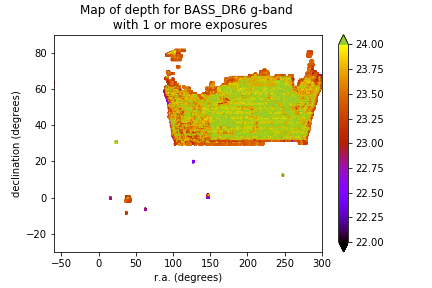

In [12]:
verbose=False
sample=mysample('BASS','DR6','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 18.98 sec for 1349303 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 19.42 sec for 1349303 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR6/nside1024_oversamp1/BASS_DR6_band_r_nside1024_oversamp1_hits__total.fits
Area is  4423.67747408  sq. deg.
1097 of  1349303  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  19.4287621882  and max  depth  =  25.0851329046
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_BASS_DR61024.png
Total pixels 1349303 probably too many for exact mean and std
Mean =  23.3132838472 ; Median =  23.3988276054 ; Std =  0.36343597125
Results for 90% 95% and 98% are:  22.8490455334 22.6911783065 22.315045435
Percentage of hits for 0,1,2., to >7 pases
[  0.00000000e+00   1.31542730e-01   2.03272356e-01   3.5

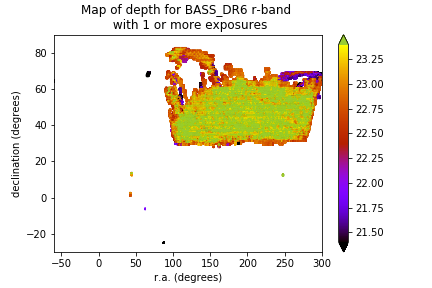

In [13]:
verbose=False
sample=mysample('BASS','DR6','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 18.56 sec for 1506382 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR6/nside1024_oversamp1/MZLS_DR6_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 19.72 sec for 1506382 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR6/nside1024_oversamp1/MZLS_DR6_band_z_nside1024_oversamp1_hits__total.fits
Area is  4938.65953071  sq. deg.
204 of  1506382  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  18.5925220537  and max  depth  =  24.4835914831
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_MZLS_DR61024.png
Total pixels 1506382 probably too many for exact mean and std
Mean =  22.8623093448 ; Median =  22.9164844401 ; Std =  0.348139395571
Results for 90% 95% and 98% are:  22.3905498139 22.1434807854 21.9984364477
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.09882752  0.15001374  0.34048601  0.2855

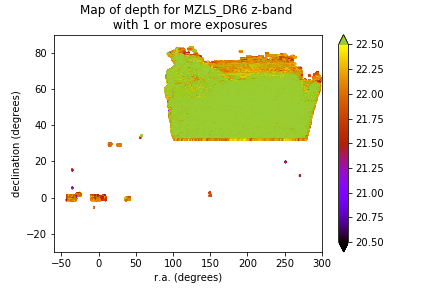

In [7]:
verbose=False
sample=mysample('MZLS','DR6','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig
#projection in some pointings to healpix pixels is not correct 
#This is only for 8 pointins and close to dec=0, usually excluded. 
#Edit careful line in quickipManera.py to check the effect
#The efect is actually a covering band around dec=0, whicn need not be there
#Keep the results without these 8 pointings is a very good approximation for what we want

### DR5 --- new

desi_image_validation.py:474: RuntimeWarning: divide by zero encountered in divide
  ivar= 1./nmag**2.


> Projection ivar  total  took : 36.34 sec for 2224544 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 31.81 sec for 2224544 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_g_nside1024_oversamp1_hits__total.fits
Area is  7293.14704177  sq. deg.
167 of  2224544  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.595955888  and max  depth  =  27.8815833825
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_DECaLS_DR51024.png
Total pixels 2224544 probably too many for exact mean and std
Mean =  24.0841589102 ; Median =  24.0855497155 ; Std =  0.469556600865
Results for 90% 95% and 98% are:  23.5362767606 23.4143113446 23.2586931671
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25407564  0.26202016  0.2008089

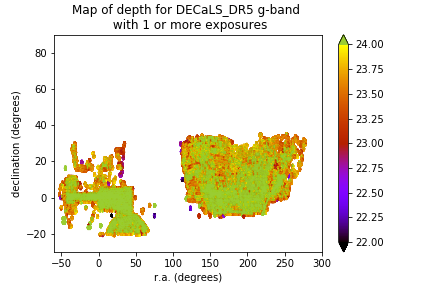

In [4]:
verbose=False
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 34.69 sec for 2364469 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 36.14 sec for 2364469 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_r_nside1024_oversamp1_hits__total.fits
Area is  7751.88986718  sq. deg.
2803 of  2364469  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  9.62868721768  and max  depth  =  27.1042250459
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_DECaLS_DR51024.png
Total pixels 2364469 probably too many for exact mean and std
Mean =  23.7048844865 ; Median =  23.6633539923 ; Std =  0.587233897579
Results for 90% 95% and 98% are:  23.0995583298 22.9843664767 22.7052595397
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25321035  0.24894512  0.19982

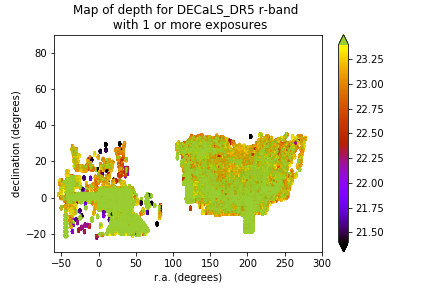

In [5]:
verbose=False
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 40.84 sec for 3089312 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 42.54 sec for 3089312 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  10128.2809753  sq. deg.
4120 of  3089312  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.1267671564  and max  depth  =  26.7398815338
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_DECaLS_DR51024.png
Total pixels 3089312 probably too many for exact mean and std
Mean =  22.7010171934 ; Median =  22.7194285397 ; Std =  0.455398619455
Results for 90% 95% and 98% are:  22.1237803017 21.9819974718 21.7854548086
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.16409487  0.20509931  0.22185

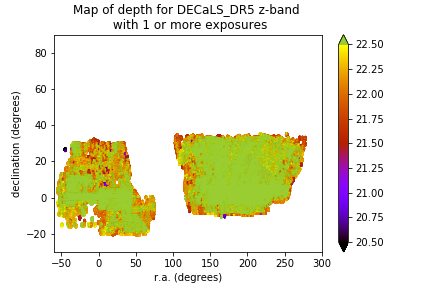

In [6]:
verbose=False
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 35.16 sec for 2224544 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 31.54 sec for 2224544 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_g_nside1024_oversamp1_hits__total.fits
Area is  3533.00332103  sq. deg.
0 of  1077631  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  22.4154471186  and max  depth  =  27.8815833825
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_DECaLS_DR51024.png
Total pixels 1077631 probably too many for exact mean and std
Mean =  24.4026438262 ; Median =  24.3391882451 ; Std =  0.407871938
Results for 90% 95% and 98% are:  24.0402448867 23.9336373995 23.7833787467
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25407564  0.26202016  0.2008089   0

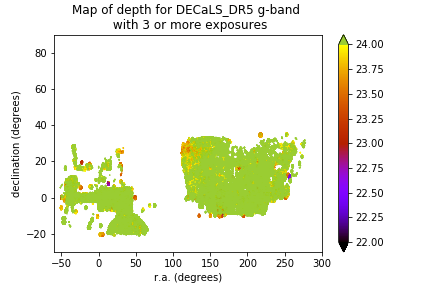

In [5]:
verbose=False
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 37.12 sec for 2364469 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 37.51 sec for 2364469 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_r_nside1024_oversamp1_hits__total.fits
Area is  3861.1671363  sq. deg.
213 of  1177727  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  9.62868721768  and max  depth  =  27.1042250459
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_DECaLS_DR51024.png
Total pixels 1177727 probably too many for exact mean and std
Mean =  24.0993055706 ; Median =  23.986513448 ; Std =  0.481940322969
Results for 90% 95% and 98% are:  23.6665610688 23.5887584435 23.4574352217
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25321035  0.24894512  0.19982516

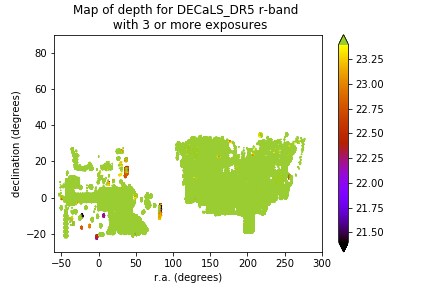

In [4]:
verbose=False
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

desi_image_validation.py:474: RuntimeWarning: divide by zero encountered in divide
  ivar= 1./nmag**2.


> Projection ivar  total  took : 47.16 sec for 3089312 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 48.51 sec for 3089312 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  6392.15219967  sq. deg.
0 of  1949724  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0816428552  and max  depth  =  26.7398815338
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_DECaLS_DR51024.png
Total pixels 1949724 probably too many for exact mean and std
Mean =  22.9348694726 ; Median =  22.8994737781 ; Std =  0.353237070573
Results for 90% 95% and 98% are:  22.5706222619 22.4494434718 22.2703581598
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.16409487  0.20509931  0.22185124

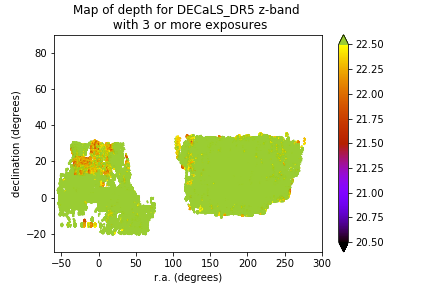

In [3]:
verbose=False
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

### DR5 -- with separation of areas

> Projection ivar  total  took : 6.79 sec for 373990 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 6.53 sec for 373990 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_g_nside1024_oversamp1_hits__total.fits
Area is  1226.12277489  sq. deg.
0 of  373990  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  22.5547623894  and max  depth  =  27.058308366
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_DEShyb_DR51024.png
Total pixels 373990 probably too many for exact mean and std
Mean =  24.391679583 ; Median =  24.3988681172 ; Std =  0.372392068385
Results for 90% 95% and 98% are:  23.9735244947 23.7907910321 23.6181638784
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.05630407  0.1150137   0.17937386  0.1987

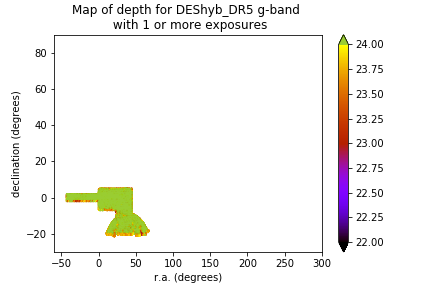

In [ ]:
verbose=False
sample=mysample('DEShyb','DR5','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:474: RuntimeWarning: divide by zero encountered in divide
  ivar= 1./nmag**2.


> Projection ivar  total  took : 18.23 sec for 1558991 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_g_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 18.27 sec for 1558991 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_g_nside1024_oversamp1_hits__total.fits
Area is  5111.13765329  sq. deg.
0 of  1558991  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.8288993648  and max  depth  =  27.8815833825
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_NGCproxy_DR51024.png
Total pixels 1558991 probably too many for exact mean and std
Mean =  24.0560281776 ; Median =  24.0549793292 ; Std =  0.455497978128
Results for 90% 95% and 98% are:  23.536539093 23.4277415888 23.2994770695
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.26086153  0.30014674  0

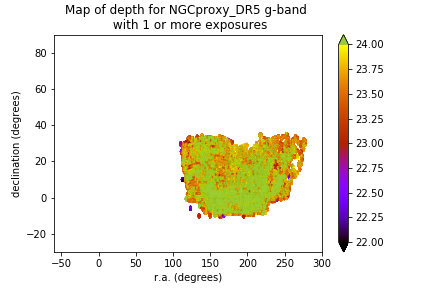

In [3]:
verbose=False
sample=mysample('NGCproxy','DR5','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 4.84 sec for 373838 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 4.79 sec for 373838 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_r_nside1024_oversamp1_hits__total.fits
Area is  1225.62444429  sq. deg.
0 of  373838  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.1246791215  and max  depth  =  27.1042250459
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_DEShyb_DR51024.png
Total pixels 373838 probably too many for exact mean and std
Mean =  24.1930822536 ; Median =  24.1418625454 ; Std =  0.434919873812
Results for 90% 95% and 98% are:  23.746712113 23.5850788031 23.4112107862
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.06266044  0.14438457  0.26366204  0.218

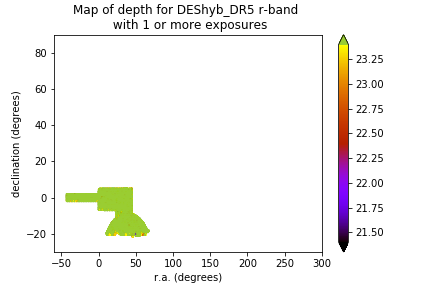

In [4]:
verbose=False
sample=mysample('DEShyb','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 17.88 sec for 1618148 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 18.14 sec for 1618148 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_r_nside1024_oversamp1_hits__total.fits
Area is  5305.08333364  sq. deg.
499 of  1618148  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.372340748  and max  depth  =  26.6376941926
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_NGCproxy_DR51024.png
Total pixels 1618148 probably too many for exact mean and std
Mean =  23.6571757799 ; Median =  23.6033890804 ; Std =  0.490095459133
Results for 90% 95% and 98% are:  23.1129980173 23.0355788039 22.9229951102
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25065636  0.2860528  

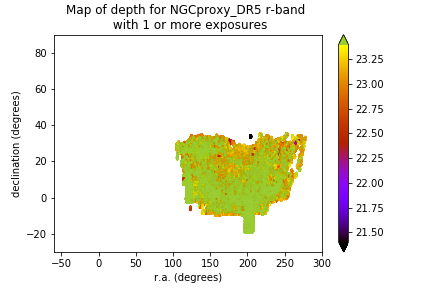

In [5]:
verbose=False
sample=mysample('NGCproxy','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 5.24 sec for 368789 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 5.31 sec for 368789 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  1209.07134423  sq. deg.
62 of  368789  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.3984952117  and max  depth  =  26.7398815338
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_DEShyb_DR51024.png
Total pixels 368789 probably too many for exact mean and std
Mean =  22.9305194863 ; Median =  22.91076812 ; Std =  0.471055956279
Results for 90% 95% and 98% are:  22.4444841089 22.2621726743 22.0467710834
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.07544372  0.14354925  0.25794241  0.255

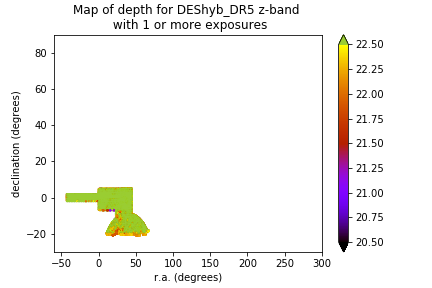

In [6]:
verbose=False
sample=mysample('DEShyb','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 20.58 sec for 1815506 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 21.00 sec for 1815506 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  5952.11972126  sq. deg.
1083 of  1815506  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  20.4826021098  and max  depth  =  24.9175907475
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_NGCproxy_DR51024.png
Total pixels 1815506 probably too many for exact mean and std
Mean =  22.7781511749 ; Median =  22.789759511 ; Std =  0.421425993989
Results for 90% 95% and 98% are:  22.2470140935 22.0680523113 21.8464422596
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.10567412  0.18553891

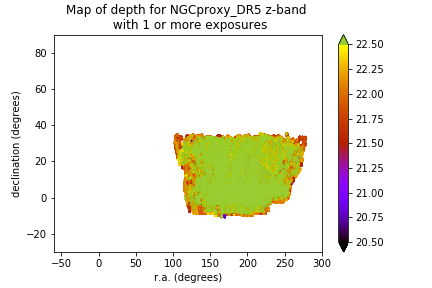

In [7]:
verbose=False
sample=mysample('NGCproxy','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

#---

> Projection ivar  total  took : 21.78 sec for 1618148 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_r_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 21.14 sec for 1618148 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_r_nside1024_oversamp1_hits__total.fits
Area is  5305.08333364  sq. deg.
499 of  1618148  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0107522556  and max  depth  =  26.6376941926
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_NGCproxy_DR51024.png
Total pixels 1617649 probably too many for exact mean and std
Mean =  23.6581045007 ; Median =  23.6035261435 ; Std =  0.487308424924
Results for 90% 95% and 98% are:  23.1133794494 23.0361629006 22.9248675779
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.25065636  0.2860528 

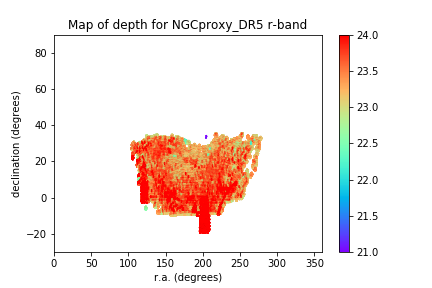

In [6]:
verbose=False
sample=mysample('NGCproxy','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 6.20 sec for 368789 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 6.16 sec for 368789 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DEShyb_DR5/nside1024_oversamp1/DEShyb_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  1209.07134423  sq. deg.
62 of  368789  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0551786346  and max  depth  =  26.7398815338
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_DEShyb_DR51024.png
Total pixels 368727 probably too many for exact mean and std
Mean =  22.9308934688 ; Median =  22.9108448803 ; Std =  0.470203971006
Results for 90% 95% and 98% are:  22.4450040617 22.2627234392 22.0500421909
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.07544372  0.14354925  0.25794241  0.2

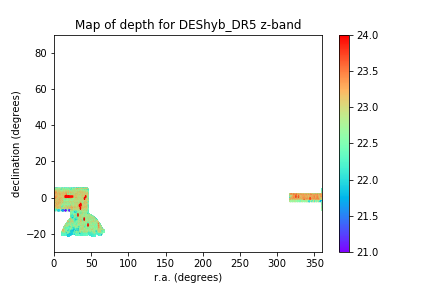

In [7]:
verbose=False
sample=mysample('DEShyb','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 25.95 sec for 1815506 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_z_nside1024_oversamp1_ivar__total.fits
> Projection hits  total  took : 24.98 sec for 1815506 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//NGCproxy_DR5/nside1024_oversamp1/NGCproxy_DR5_band_z_nside1024_oversamp1_hits__total.fits
Area is  5952.11972126  sq. deg.
1083 of  1815506  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.000382906  and max  depth  =  24.9175907475
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_NGCproxy_DR51024.png
Total pixels 1814423 probably too many for exact mean and std
Mean =  22.7792680608 ; Median =  22.7899936617 ; Std =  0.419059129447
Results for 90% 95% and 98% are:  22.2491653981 22.0709323416 21.8534469578
Percentage of hits for 0,1,2., to >7 pases
[ 0.          0.10567412  0.18553891

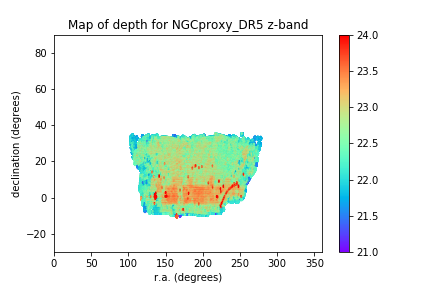

In [8]:
verbose=False
sample=mysample('NGCproxy','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

### DR4

> Projection ivar  total  took : 28.13 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_ivar__total.fits
Area is  3386.54985843  sq. deg.
6391 of  1032960  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.492640974  and max  depth  =  25.2674991197
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_BASS_DR41024.png


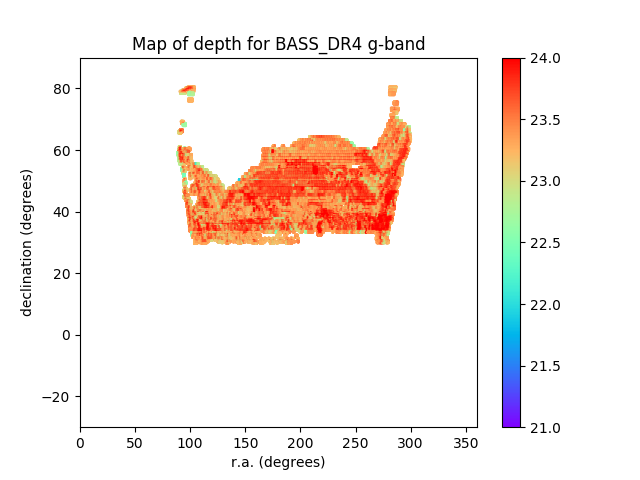

In [4]:
verbose=False
sample=mysample('BASS','DR4','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 24.13 sec for 900041 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_ivar__total.fits
Area is  2950.77613957  sq. deg.
3553 of  900041  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0032415064  and max  depth  =  24.093121473
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_BASS_DR41024.png


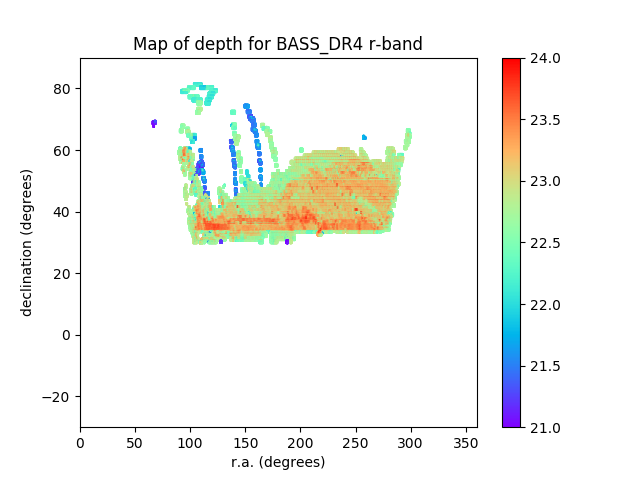

In [5]:
verbose=False
sample=mysample('BASS','DR4','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 28.03 sec for 1003899 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_ivar__total.fits
Area is  3363.76762585  sq. deg.
6788 of  1026011  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0101700532  and max  depth  =  23.5305051132
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_MZLS_DR41024.png


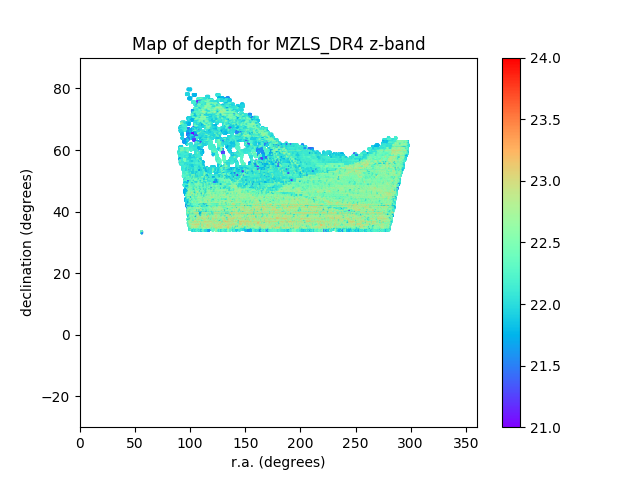

In [6]:
verbose=False
sample=mysample('MZLS','DR4','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

### Depth Histograms (Val 3.4)

Requirement V3.4<br>
90% filled to g=24, r=23.4 and z=22.5 and 95% and 98% at 0.3/0.6 mag shallower.<br>
Done by montecarlo exposure statistics to the final ratio of exposures

-----------
Number of objects =  46504
Counts with dec < -20 =  2
Number of objects in the sample =  46504
Total images drawn with either  3  to 5 exposures 94000
We are in fact runing with a minimum of 3 exposures
Mean =  23.4064689993 ; Median =  23.4153847059 ; Std =  0.138250546623
percentage better than requirements = 0.554617021277
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.2365012299 23.1719960187 23.0835890265
min,max depth =  22.0342805845 24.0322437349
counts below  22.0342805845  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR6r_pred_exposures.png


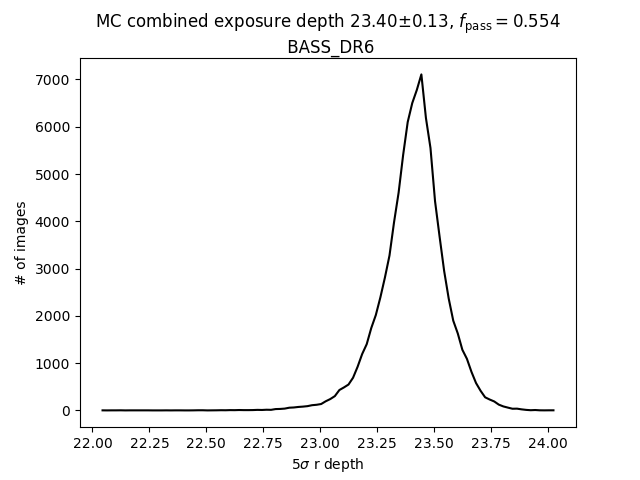

In [3]:
verbose=True
sample=mysample('BASS','DR6','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  44144
Counts with dec < -20 =  0
Number of objects in the sample =  44144
Total images drawn with either  3  to 5 exposures 94000
We are in fact runing with a minimum of 3 exposures
Mean =  24.0113015814 ; Median =  24.0057597833 ; Std =  0.110369677706
percentage better than requirements = 0.526031914894
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8844140965 23.8407735112 23.7842311659
min,max depth =  23.269073722 24.6196708816
counts below  23.269073722  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR6g_pred_exposures.png


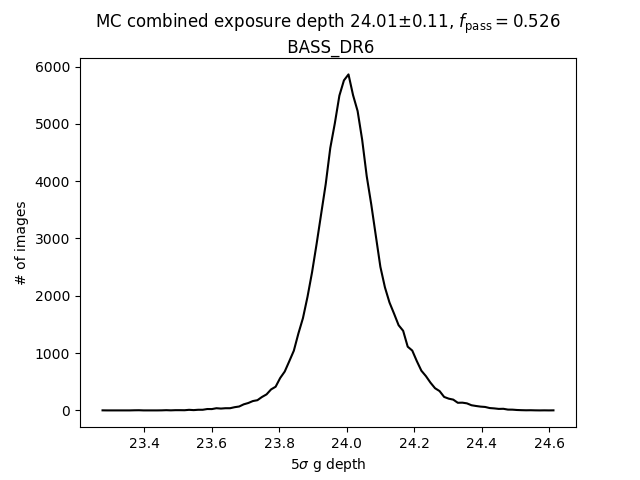

In [4]:
verbose=True
sample=mysample('BASS','DR6','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  170275
Counts with dec < -20 =  0
Number of objects in the sample =  170275
Total images drawn with either  3  to 5 exposures 85000
We are in fact runing with a minimum of 3 exposures
Mean =  22.8756863631 ; Median =  22.8785879342 ; Std =  0.109481630925
percentage better than requirements = 0.998117647059
Requirements are > 90%, 95% and 98% at 22.5, 22.2, 21.9
Results are:  22.7373845223 22.6917459818 22.6363413819
min,max depth =  22.0268959928 23.4105805504
counts below  22.0268959928  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/MZLS_DR6z_pred_exposures.png


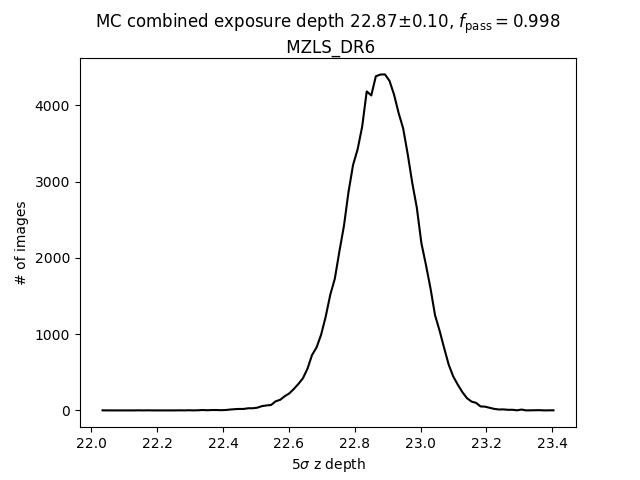

In [5]:
verbose=True
sample=mysample('MZLS','DR6','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  46504
Counts with dec < -20 =  2
Number of objects in the sample =  46504
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.3907023928 ; Median =  23.4073605915 ; Std =  0.153943390585
percentage better than requirements = 0.52417
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.2011858551 23.1263590664 23.0137473029
min,max depth =  21.2522716522 24.0247590354
counts below  21.2522716522  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR6r_pred_exposures.png


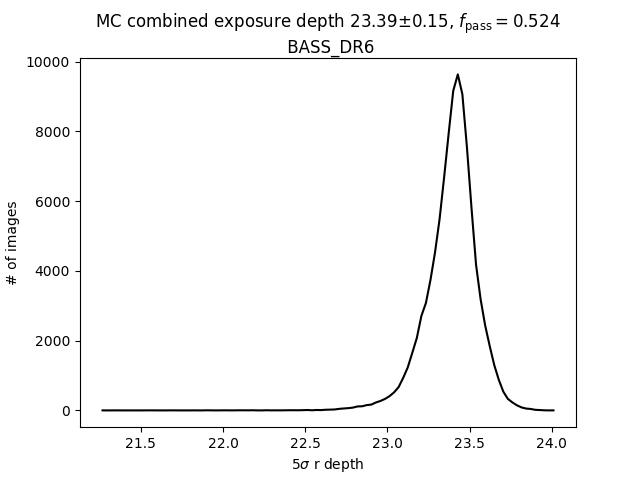

In [6]:
verbose=True
sample=mysample('BASS','DR6','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  44144
Counts with dec < -20 =  0
Number of objects in the sample =  44144
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.9956057783 ; Median =  23.999128876 ; Std =  0.127058290303
percentage better than requirements = 0.49628
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8465776971 23.7800987959 23.7019013866
min,max depth =  22.4918347067 24.571176415
counts below  22.4918347067  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR6g_pred_exposures.png


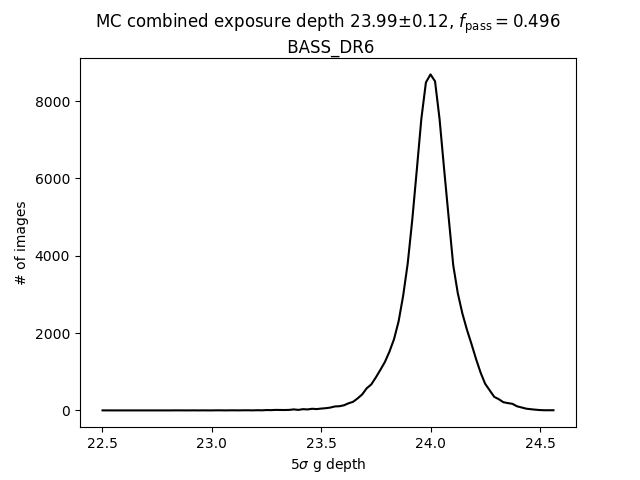

In [7]:
verbose=True
sample=mysample('BASS','DR6','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  170275
Counts with dec < -20 =  0
Number of objects in the sample =  170275
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8406463589 ; Median =  22.8578349069 ; Std =  0.145157408664
percentage better than requirements = 0.97708
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.6550506655 22.5778112716 22.4852127441
min,max depth =  20.5390491486 23.4310196081
counts below  21.0  =  1
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/MZLS_DR6z_pred_exposures.png


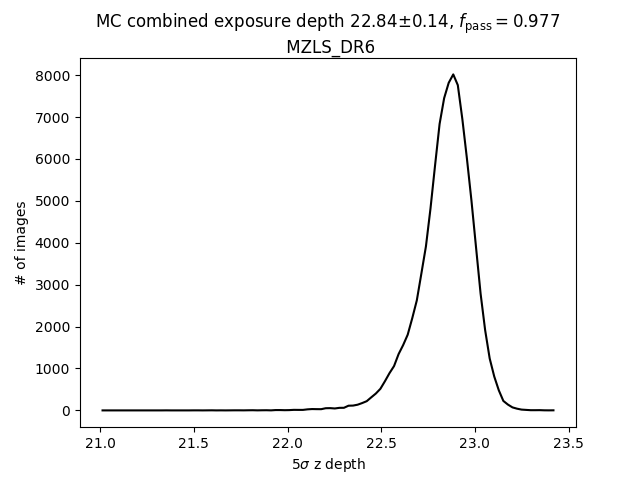

In [8]:
verbose=True
sample=mysample('MZLS','DR6','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

#### DR5 

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  539702
Total images drawn with either  3  to 5 exposures 74000
We are in fact runing with a minimum of 3 exposures
Mean =  23.930464184 ; Median =  23.8823995833 ; Std =  0.301782184199
percentage better than requirements = 0.982756756757
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.6002718727 23.5163412935 23.4160328602
min,max depth =  22.3405577961 25.0485798493
counts below  22.3405577961  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5r_pred_exposures.png


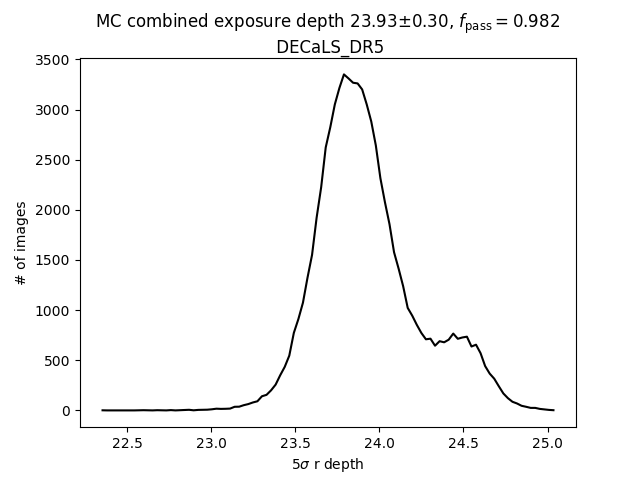

In [6]:
verbose=True
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  528626
Total images drawn with either  3  to 5 exposures 74000
We are in fact runing with a minimum of 3 exposures
Mean =  24.2889079077 ; Median =  24.2911943506 ; Std =  0.208254722944
percentage better than requirements = 0.923337837838
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  24.0328228431 23.9482944181 23.8384076416
min,max depth =  22.7928264155 25.4469867488
counts below  22.7928264155  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5g_pred_exposures.png


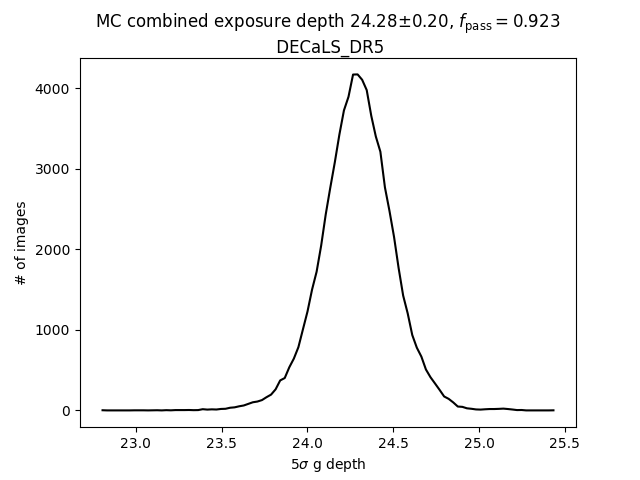

In [7]:
verbose=True
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  689388
Total images drawn with either  3  to 5 exposures 74000
We are in fact runing with a minimum of 3 exposures
Mean =  22.893711822 ; Median =  22.8759292993 ; Std =  0.23372262471
percentage better than requirements = 0.964986486486
Requirements are > 90%, 95% and 98% at 22.5, 22.2, 21.9
Results are:  22.6144456748 22.53684198 22.4466028971
min,max depth =  21.4719591142 23.7729037715
counts below  21.4719591142  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5z_pred_exposures.png


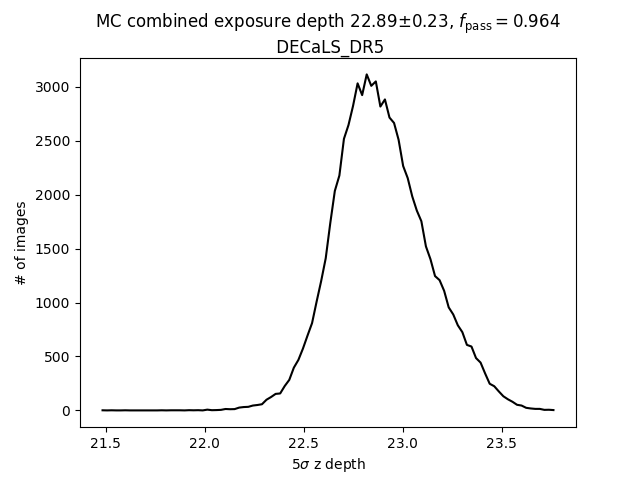

In [8]:
verbose=True
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample,Nexpmin=3)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  528626
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.2047074997 ; Median =  24.2300236032 ; Std =  0.27099848879
percentage better than requirements = 0.81038
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8717687463 23.7423485852 23.5604571827
min,max depth =  21.4889698029 25.3586243634
counts below  21.4889698029  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5g_pred_exposures.png


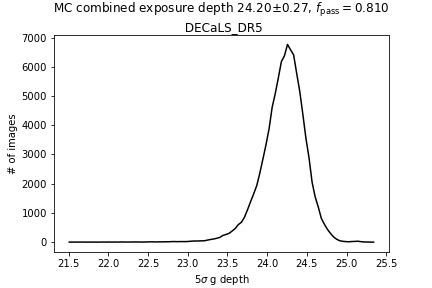

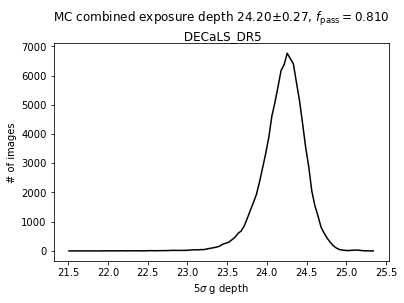

In [13]:
verbose=True
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  539702
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.8425509351 ; Median =  23.8175633515 ; Std =  0.356554523213
percentage better than requirements = 0.91876
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.4389074448 23.3052346175 23.1321868185
min,max depth =  20.46667099 25.2130308881
counts below  21.0  =  5
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5r_pred_exposures.png


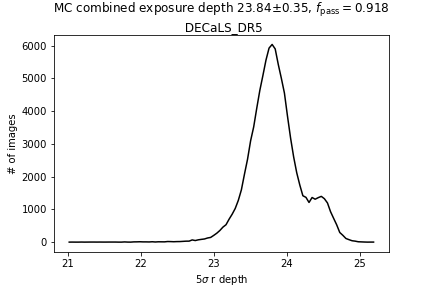

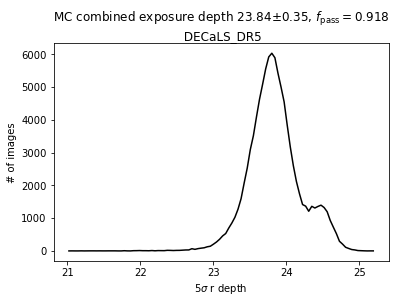

In [11]:
verbose=True
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts with dec < -20 =  13075
Number of objects in the sample =  689388
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8074812513 ; Median =  22.8124018609 ; Std =  0.290604817308
percentage better than requirements = 0.8689
Requirements are > 90%, 95% and 98% at 22.5, 22.2, 21.9
Results are:  22.452211846 22.3270688857 22.1633448784
min,max depth =  19.9536361694 23.8367842017
counts below  21.0  =  10
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5z_pred_exposures.png


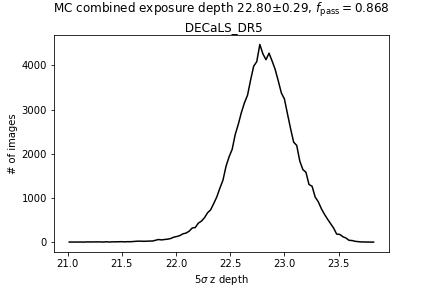

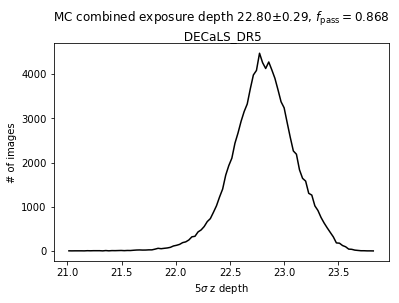

In [12]:
verbose=True
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

#### ---- old DR5 ----

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  124159
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.1838370518 ; Median =  24.2099142499 ; Std =  0.280599884812
percentage better than requirements = 0.78104
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8360147465 23.7010912612 23.5122098509
min,max depth =  21.3609409332 25.0236269297
counts below  21.3609409332  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DEShyb_DR5g_pred_exposures.png


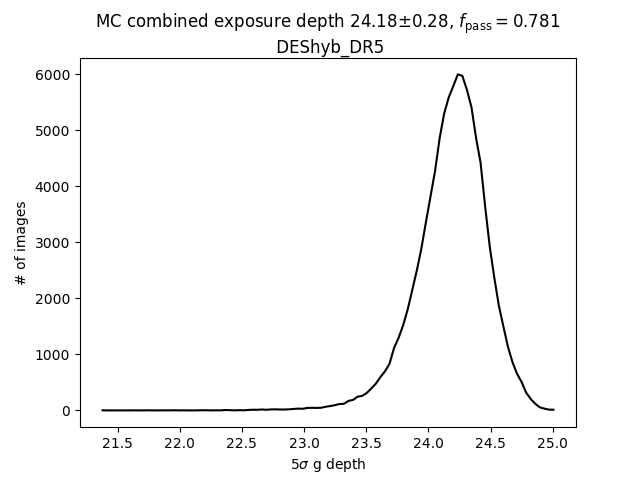

In [5]:
verbose=True
sample=mysample('DEShyb','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

creating directory for plots /global/homes/m/manera/DESI/validation-outputs/NGCproxy_DR5
-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  366804
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.2153387468 ; Median =  24.2418202086 ; Std =  0.267397248547
percentage better than requirements = 0.82598
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8909109582 23.7597470263 23.5700310399
min,max depth =  21.1560192108 25.2931528002
counts below  21.1560192108  =  0
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/NGCproxy_DR5g_pred_exposures.png


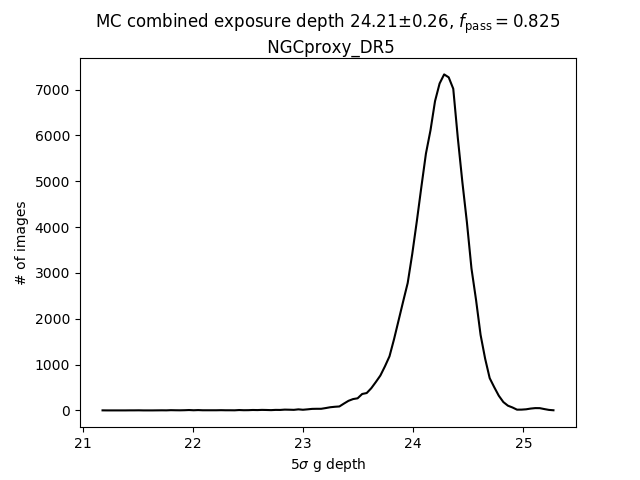

In [6]:
verbose=True
sample=mysample('NGCproxy','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

creating directory for plots /global/homes/m/manera/DESI/validation-outputs/DECaLS_DR5
-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  528626
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.2048776006 ; Median =  24.2304521411 ; Std =  0.275360980801
percentage better than requirements = 0.80966
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8708821524 23.7365246903 23.5536577492
min,max depth =  20.7588405609 25.2655482125
counts below  21.0  =  2
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5g_pred_exposures.png


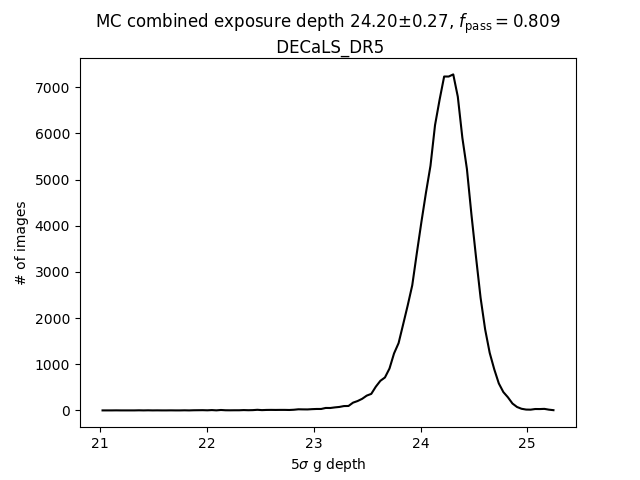

In [7]:
verbose=True
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  111905
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.0967350952 ; Median =  24.0844806187 ; Std =  0.334522276514
percentage better than requirements = 0.97785
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.7021382403 23.5637934786 23.382436418
min,max depth =  20.5994987488 25.1288276243
counts below  21.0  =  4
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DEShyb_DR5r_pred_exposures.png


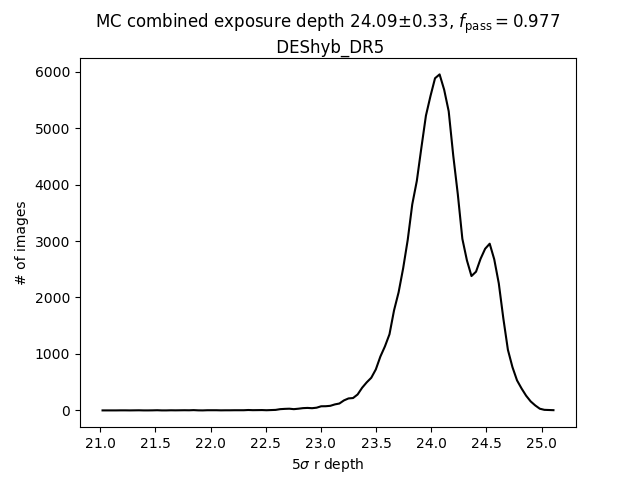

In [8]:
verbose=True
sample=mysample('DEShyb','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  351752
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.7644127247 ; Median =  23.741426656 ; Std =  0.322339405322
percentage better than requirements = 0.91678
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.4297006979 23.3178598232 23.156239727
min,max depth =  -0.0688880085945 25.0804602131
counts below  21.0  =  4
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/NGCproxy_DR5r_pred_exposures.png


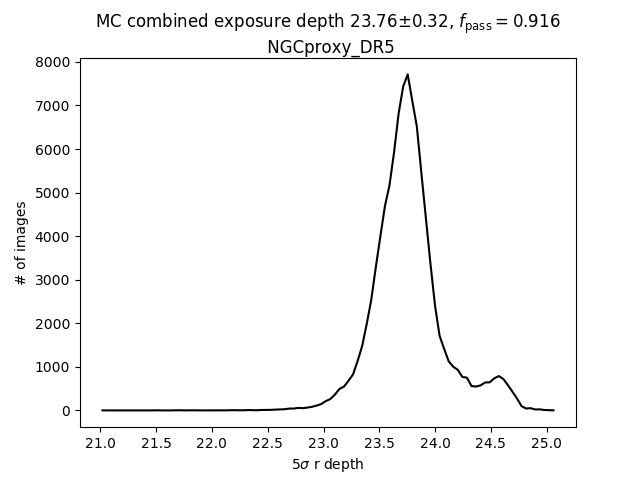

In [9]:
verbose=True
sample=mysample('NGCproxy','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  539702
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.8413805348 ; Median =  23.8170753056 ; Std =  0.364457871284
percentage better than requirements = 0.91804
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.4381448292 23.3047377957 23.1292440372
min,max depth =  -0.0688880085945 25.0559045881
counts below  21.0  =  5
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5r_pred_exposures.png


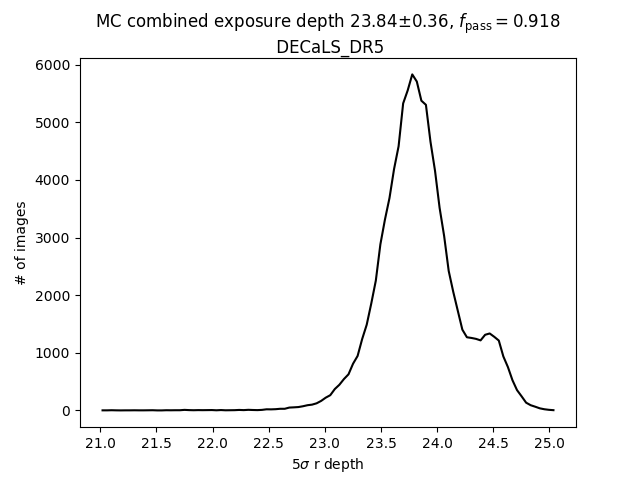

In [11]:
verbose=True
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  140737
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.0642600205 ; Median =  23.0925442784 ; Std =  0.309003850329
percentage better than requirements = 0.95529
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.657506824 22.5223158002 22.3455825154
min,max depth =  20.0157680511 23.9200181911
counts below  21.0  =  2
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DEShyb_DR5z_pred_exposures.png


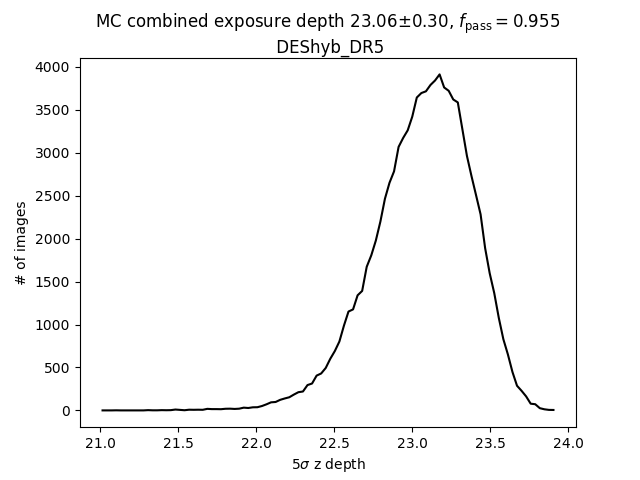

In [12]:
verbose=True
sample=mysample('DEShyb','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  416107
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.753287841 ; Median =  22.7655239658 ; Std =  0.249418436836
percentage better than requirements = 0.86126
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.4459195799 22.335141552 22.1808316012
min,max depth =  20.3578929901 23.6471932569
counts below  21.0  =  16
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/NGCproxy_DR5z_pred_exposures.png


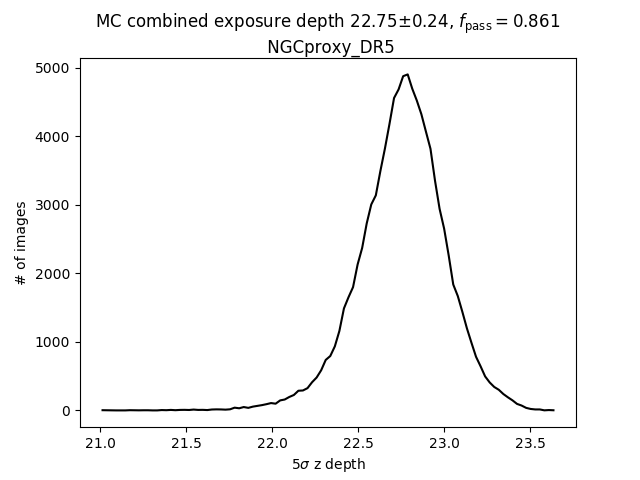

In [13]:
verbose=True
sample=mysample('NGCproxy','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  689388
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8064779956 ; Median =  22.8126459375 ; Std =  0.292226721611
percentage better than requirements = 0.86885
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.4521908377 22.322765752 22.1597849906
min,max depth =  20.3543758392 23.7643932756
counts below  21.0  =  19
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5z_pred_exposures.png


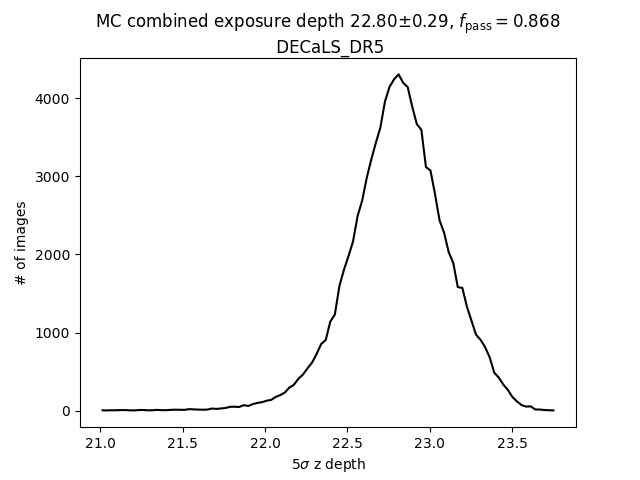

In [14]:
verbose=True
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  49032
Counts before or during 2014 =  0
Counts with dec < -20 =  16
Number of objects in the sample =  21919
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.9078045632 ; Median =  23.916499922 ; Std =  0.157173139042
percentage better than requirements = 0.22469
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.7394484346 23.6691735204 23.5798986111
min,max depth =  4.4408920985e-15 24.4988843412
counts below  21.0  =  1
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR4g_pred_exposures.png


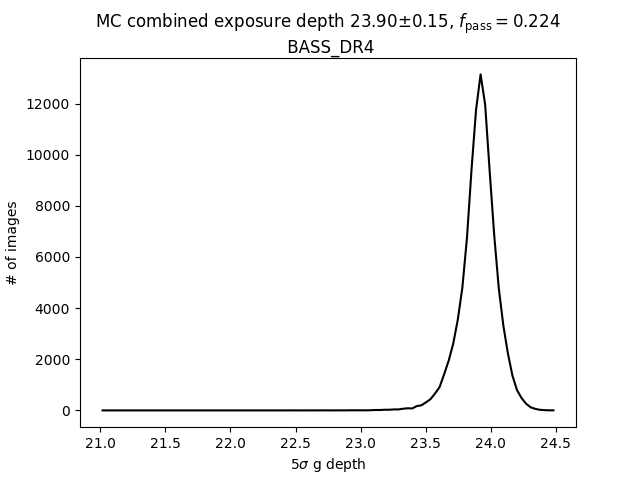

In [3]:
verbose=True
sample=mysample('BASS','DR4','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  49032
Counts before or during 2014 =  0
Counts with dec < -20 =  16
Number of objects in the sample =  23718
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.3125535232 ; Median =  23.3314726417 ; Std =  0.242451537445
percentage better than requirements = 0.28556
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.1149276268 23.0344432049 22.915762313
min,max depth =  4.4408920985e-15 23.9711193767
counts below  21.0  =  7
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR4r_pred_exposures.png


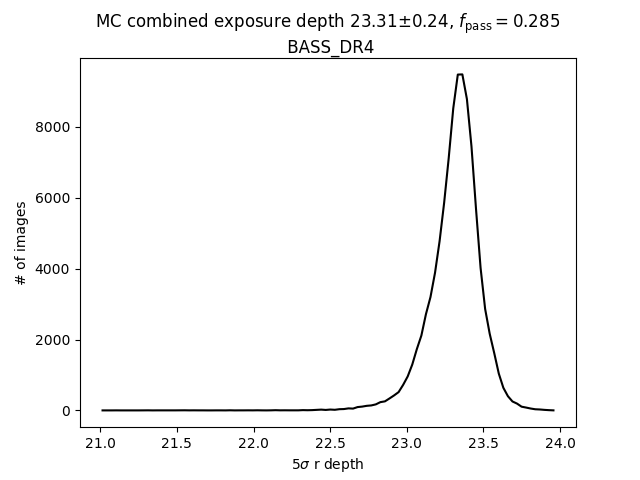

In [4]:
verbose=True
sample=mysample('BASS','DR4','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  80486
Counts before or during 2014 =  0
Counts with dec < -20 =  0
Number of objects in the sample =  72150
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8105140816 ; Median =  22.8344044032 ; Std =  0.2607307769
percentage better than requirements = 0.96722
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.6225030872 22.5438015882 22.4455493114
min,max depth =  4.4408920985e-15 23.2442334432
counts below  21.0  =  9
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/MZLS_DR4z_pred_exposures.png


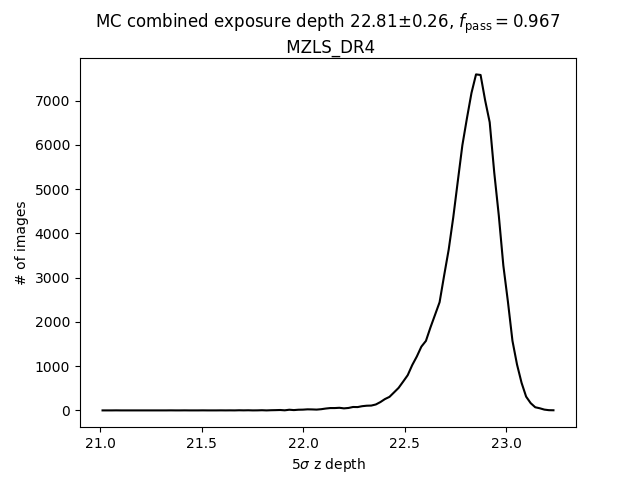

In [5]:
verbose=True
sample=mysample('MZLS','DR4','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

### Seeing Requirements (Val 4.1)

z-band image quality will be smaller than 1.3 arcsec FWHM in at least one pass.<br>

val3p4c_seeing        - runs everything <br>
val3p4c_seeingplots   - runs the plots only if the previous have been run

> Projection FWHM  min  took : 23.44 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_FWHM__min.fits
> Projection FWHM  num  took : 20.59 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_FWHM__num.fits
2.37794 9.52291
1.0 38.0
1032960 131050
2.37794 7.25379
saving plot to  /global/homes/m/manera/DESI/validation-outputs/FWHMminpass3_g_BASS_DR41024map.png
The total area is  3386.54985843  sq. deg.
A total of  429.64621955 squaredegrees with pass >= 3
#FWHM  Area(>FWHM) Fractional Area(>FWHM)
1.29369443974 3.70141611501 0.00863037678589
#mean  STD
3.31503719954 0.451763193891
Area with FWHM greater than 1.3 arcsec fraction
3.70 0.01
saving plot to  /global/homes/m/manera/DESI/validation-outputs/FWHMminpass3_g_BASS_DR41024histo.png
For pass >=3


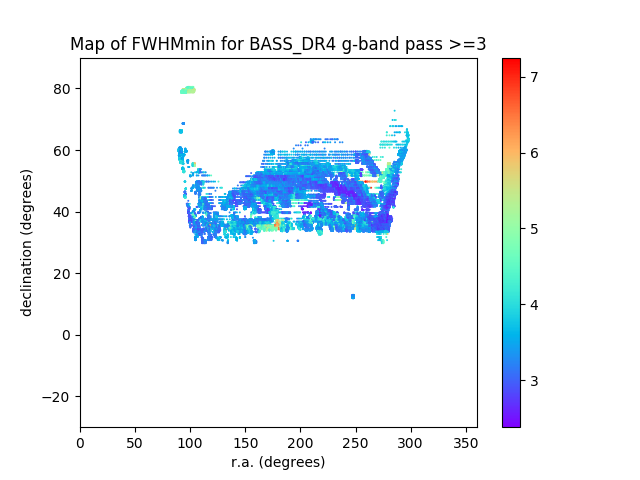

In [3]:
verbose=True
sample= mysample('BASS','DR4','g',localdir,verbose)
#fname1,fname2 = val3p4c_seeing(sample)
fname1, fname2 = val3p4c_seeing(sample)
print 'For pass >=3'
fig = Image(filename=(fname1))
fig

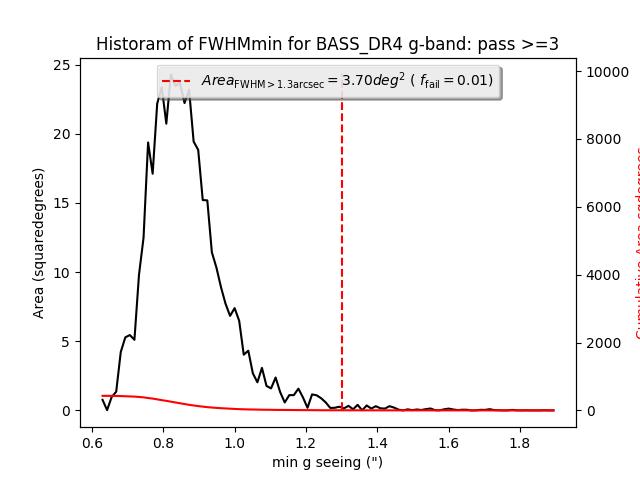

In [4]:
fig = Image(filename=(fname2))
fig

### Photometric Requirements (Val 5.1e)

Requirement V5.1<br>
No region > 3deg will be based upon non-photometric observations<br>
Done by visual inspection and if necessary pixel value counts.<br>

> Projection zptvar  min  took : 20.32 sec for 1040981 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.000341442358971 0.010842128031
Number of pixels is  1040981
Area is  3412.84663315  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.01  for all subpixels = 0
nside of udgraded pixels is :  64


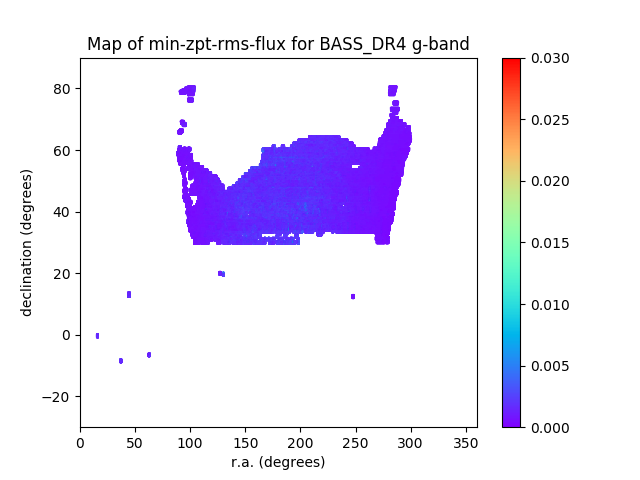

In [7]:
verbose=False
sample = mysample('BASS','DR4','g',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:447: RuntimeWarning: divide by zero encountered in divide
  zptvar = tbdata['CCDPHRMS']**2/tbdata['CCDNMATCH']


> Projection zptvar  min  took : 17.61 sec for 908419 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.000370434955345 0.00748266271781
Number of pixels is  908419
Area is  2978.2433355  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.01  for all subpixels = 0
nside of udgraded pixels is :  64


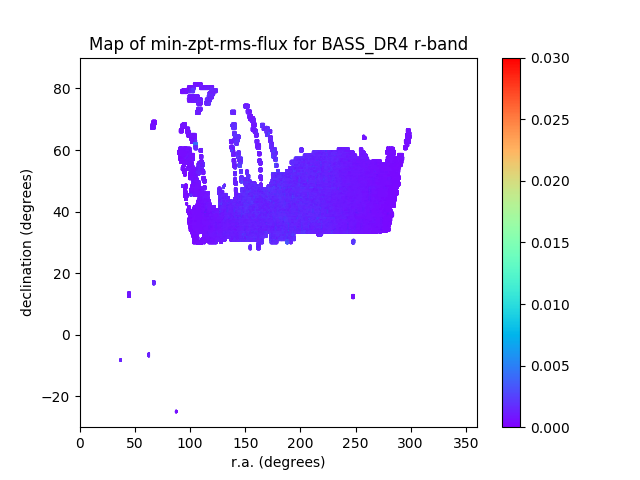

In [6]:
verbose=False
sample = mysample('BASS','DR4','r',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:454: RuntimeWarning: divide by zero encountered in divide
  zptvar = tbdata['CCDPHRMS']**2/tbdata['CCDNMATCH']


> Projection zptvar  min  took : 94.96 sec for 1014477 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.00073402407614 0.0432843339667
Number of pixels is  1014477
Area is  3325.95351294  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.02  for all subpixels = 0
nside of udgraded pixels is :  64


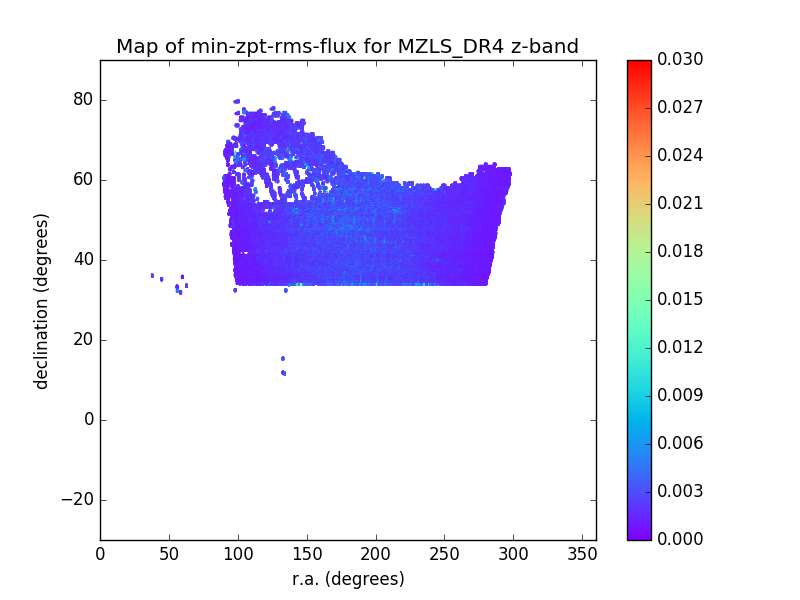

In [3]:
verbose=False
sample = mysample('MZLS','DR4','z',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

### Area Requirements (Val 5.3 and Val 3.1)

Requirement V5.1<br>
450 sq degrees overlap between all instruments br>
Requirement V3.1<br> 
1200 sq degrees filled <br> 

> Projection nccd1  total  took : 16.34 sec for 896872 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_g_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 18.89 sec for 1040981 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  2940.0  sq. deg.
Area of sample BASS_DR4  is  3413.0  sq. deg.
The total JOINT area is  6324.0 sq. deg.
The INTERSECTING area is  29.0  sq. deg.


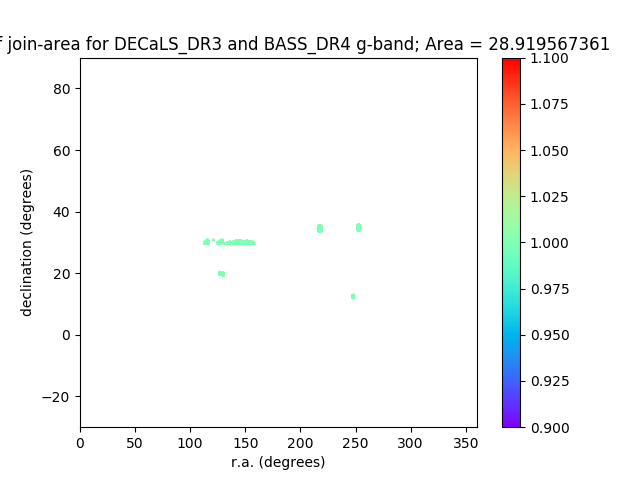

In [4]:
verbose=False
sample1 = mysample('DECaLS','DR3','g',localdir,verbose)
sample2 = mysample('BASS','DR4','g',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

> Projection nccd1  total  took : 16.55 sec for 929020 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_r_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 17.57 sec for 908419 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  3046.0  sq. deg.
Area of sample BASS_DR4  is  2978.0  sq. deg.
The total JOINT area is  6008.0 sq. deg.
The INTERSECTING area is  16.0  sq. deg.


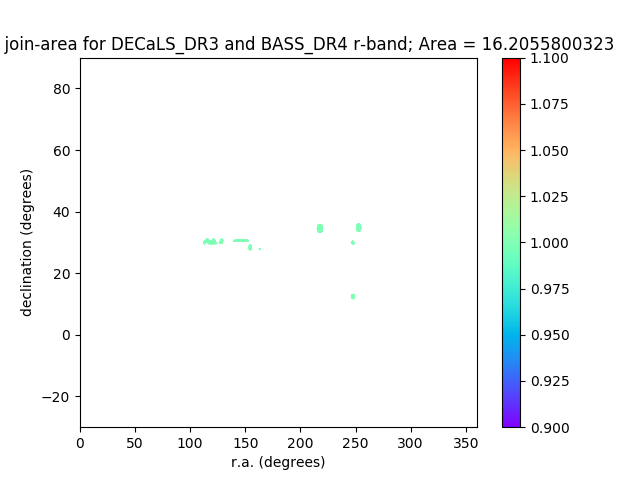

In [5]:
verbose=False
sample1 = mysample('DECaLS','DR3','r',localdir,verbose)
sample2 = mysample('BASS','DR4','r',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

> Projection nccd1  total  took : 38.14 sec for 2086258 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_z_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 18.47 sec for 1014477 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  6840.0  sq. deg.
Area of sample MZLS_DR4  is  3326.0  sq. deg.
The total JOINT area is  10138.0 sq. deg.
The INTERSECTING area is  28.0  sq. deg.


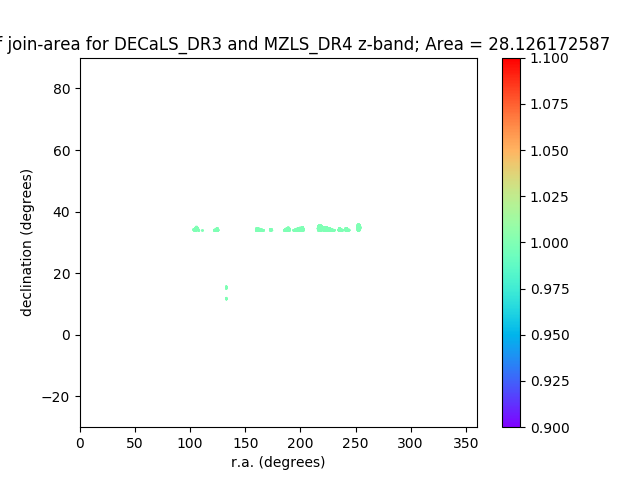

In [3]:
verbose=False
sample1 = mysample('DECaLS','DR3','z',localdir,verbose)
sample2 = mysample('MZLS','DR4','z',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

###  OLD TEST  Read Header and files

In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
from multiprocessing import Pool
import matplotlib as mpl
## mpl.use('Agg')
import matplotlib.pyplot as plt

from quicksipManera import *

In [2]:
inputdir='/project/projectdirs/cosmo/data/legacysurvey/dr3/'
localdir = '/global/homes/m/manera/DESI/validation-outputs/' 
fname = inputdir+'ccds-annotated-decals.fits.gz'

In [ ]:
# Obtain Header and DATA 
tbdataDR3 = pyfits.open(fname)[1].data
headerDR3=pyfits.open(fname)[1].header
print len(tbdataDR3)
headerDR3

In [3]:
# Compare extinction values 
gdepth=tbdataDR3['galdepth'][indsDR3]
ebv=tbdataDR3['EBV'][indsDR3]
exti=tbdataDR3['decam_extinction'][indsDR3][:,1]
print ebv
print exti #compare exti with ebv*3.303

In [ ]:
# Select particular indices
indsDR4 = np.where((tbdataDR3['filter'] == 'g') & (tbdataDR3['photometric'] == True) & (tbdataDR3['blacklist_ok'] == True))
print np.size(indsDR3)

In [ ]:
# Inspect one item
ic=69720
print tbdataDR3['galdepth'][ic]
print tbdataDR3['height'][ic]
print tbdataDR3['CRPIX1'][ic]
print tbdataDR3['CD1_2'][ic]
print tbdataDR3['CRVAL1'][ic], tbdataDR3['CRVAL2'][ic]
print tbdataDR3['RA0'][ic], tbdataDR3['RA1'][ic],tbdataDR3['RA2'][ic], tbdataDR3['RA3'][ic]
print tbdataDR3['DEC0'][ic], tbdataDR3['DEC1'][ic],tbdataDR3['DEC2'][ic], tbdataDR3['DEC3'][ic]
print tbdataDR3['RA'][ic], tbdataDR3['DEC'][ic]
print tbdataDR3['decam_extinction'][ic]

### OLD TEST :Compare extinction corrected magnitudes obtained in various ways

In [12]:
def nanomaggiesToMag(nm):
        return -2.5 * (log(nm,10.) - 9.)
def Magtonanomaggies(m):
        return 10.**(-m/2.5+9.)

In [13]:
# Way 1 
    ext = 0.13
    mag = 22.5
    detsig1 = Magtonanomaggies(mag)/5. #total noise
    signalext = 1./10.**(-ext/2.5)
    nmagNew=detsig1*signalext
    print nmagNew

0.225439491235


In [14]:
# Way 2
    ext = 0.13
    mag = 22.5
    mag2 = mag -ext
    detsig1 = Magtonanomaggies(mag2)/5. #total noise
    nmagNew=detsig1
    print nmagNew

0.225439491235
